In [5]:
from IPython.display import display, HTML
hide_prompt_style = """
<style>
/* JupyterLab 기준, InputPrompt/OutputPrompt 클래스 숨기기 */
.lm-Widget.jp-InputPrompt.jp-InputArea-prompt,
.lm-Widget.jp-OutputPrompt.jp-OutputArea-prompt {
    display: none !important;
}
</style>
"""

display(HTML(hide_prompt_style))

머신러닝1
- 강판 결함에 관한 데이터셋이다. 강판 결함은 Pastry,  Z_Scratch,  K_Scatch,  Stains,  Dirtiness,  Bumps,  Other_Faults로 총 7가지가 존재합니다.

머신러닝1-1    
아래의 기준으로 전처리하라
1. 강판결함 7종은 원핫인코딩으로 되어있다. 두가지 이상의 결함이 동시에 존재하는 데이터와 결함이 하나도 존재하지 않는 노이즈 데이터 행을 제거하고    
원핫인코딩 컬럼을 하나의 종속변수 컬럼(컬럼명 y)으로 만들고 각 결함을 알파벳 순으로 정렬하여 1~7까지 매핑하여 나타내라.
2. 종속변수 관련 데이터는 y 컬럼만 남기고 모두 제거한다.
3. 종속변수를 제외하고 unique값이 100개 이하인 컬럼은 제거하라

In [6]:
import pandas as pd

In [99]:
df =pd.read_csv('steel.csv')
d = df[df.iloc[:,-7:].sum(axis=1) ==1].reset_index(drop=True).copy()
# method1
dic = {}

n=1
for each_ in sorted(d.iloc[:,-7:].columns):
    dic[each_] = n
    n+=1

# method2
dic = {each_:i+1 for i, each_ in enumerate(sorted(d.iloc[:,-7:].columns))}
target_col = d.columns[-7:]
for col in target_col:
    d[col] = d[col].map({0:'',1:col})
    

d['y'] = d.iloc[:,-7:].sum(axis=1).map(dic)
d = d.drop(columns =target_col)
d.head(2)
remove_col = d.nunique()[d.nunique() <=100][:-1].index
d = d.drop(columns =remove_col)

머신러닝1-2    
이상치 처리 후 데이터 EDA 시각화 포함

In [101]:
pd.set_option('display.max_columns',50) # 최대 컬럼수
# pd.set_option('display.max_rows',50) # output 셀에서 출력되는 최대 행수
# pd.set_option('display.max_colwith',50) # 각 value의 출력 최대 길이

In [102]:
# d.describe().iloc[:,1:-1].loc[['mean','50%','min','max']].T

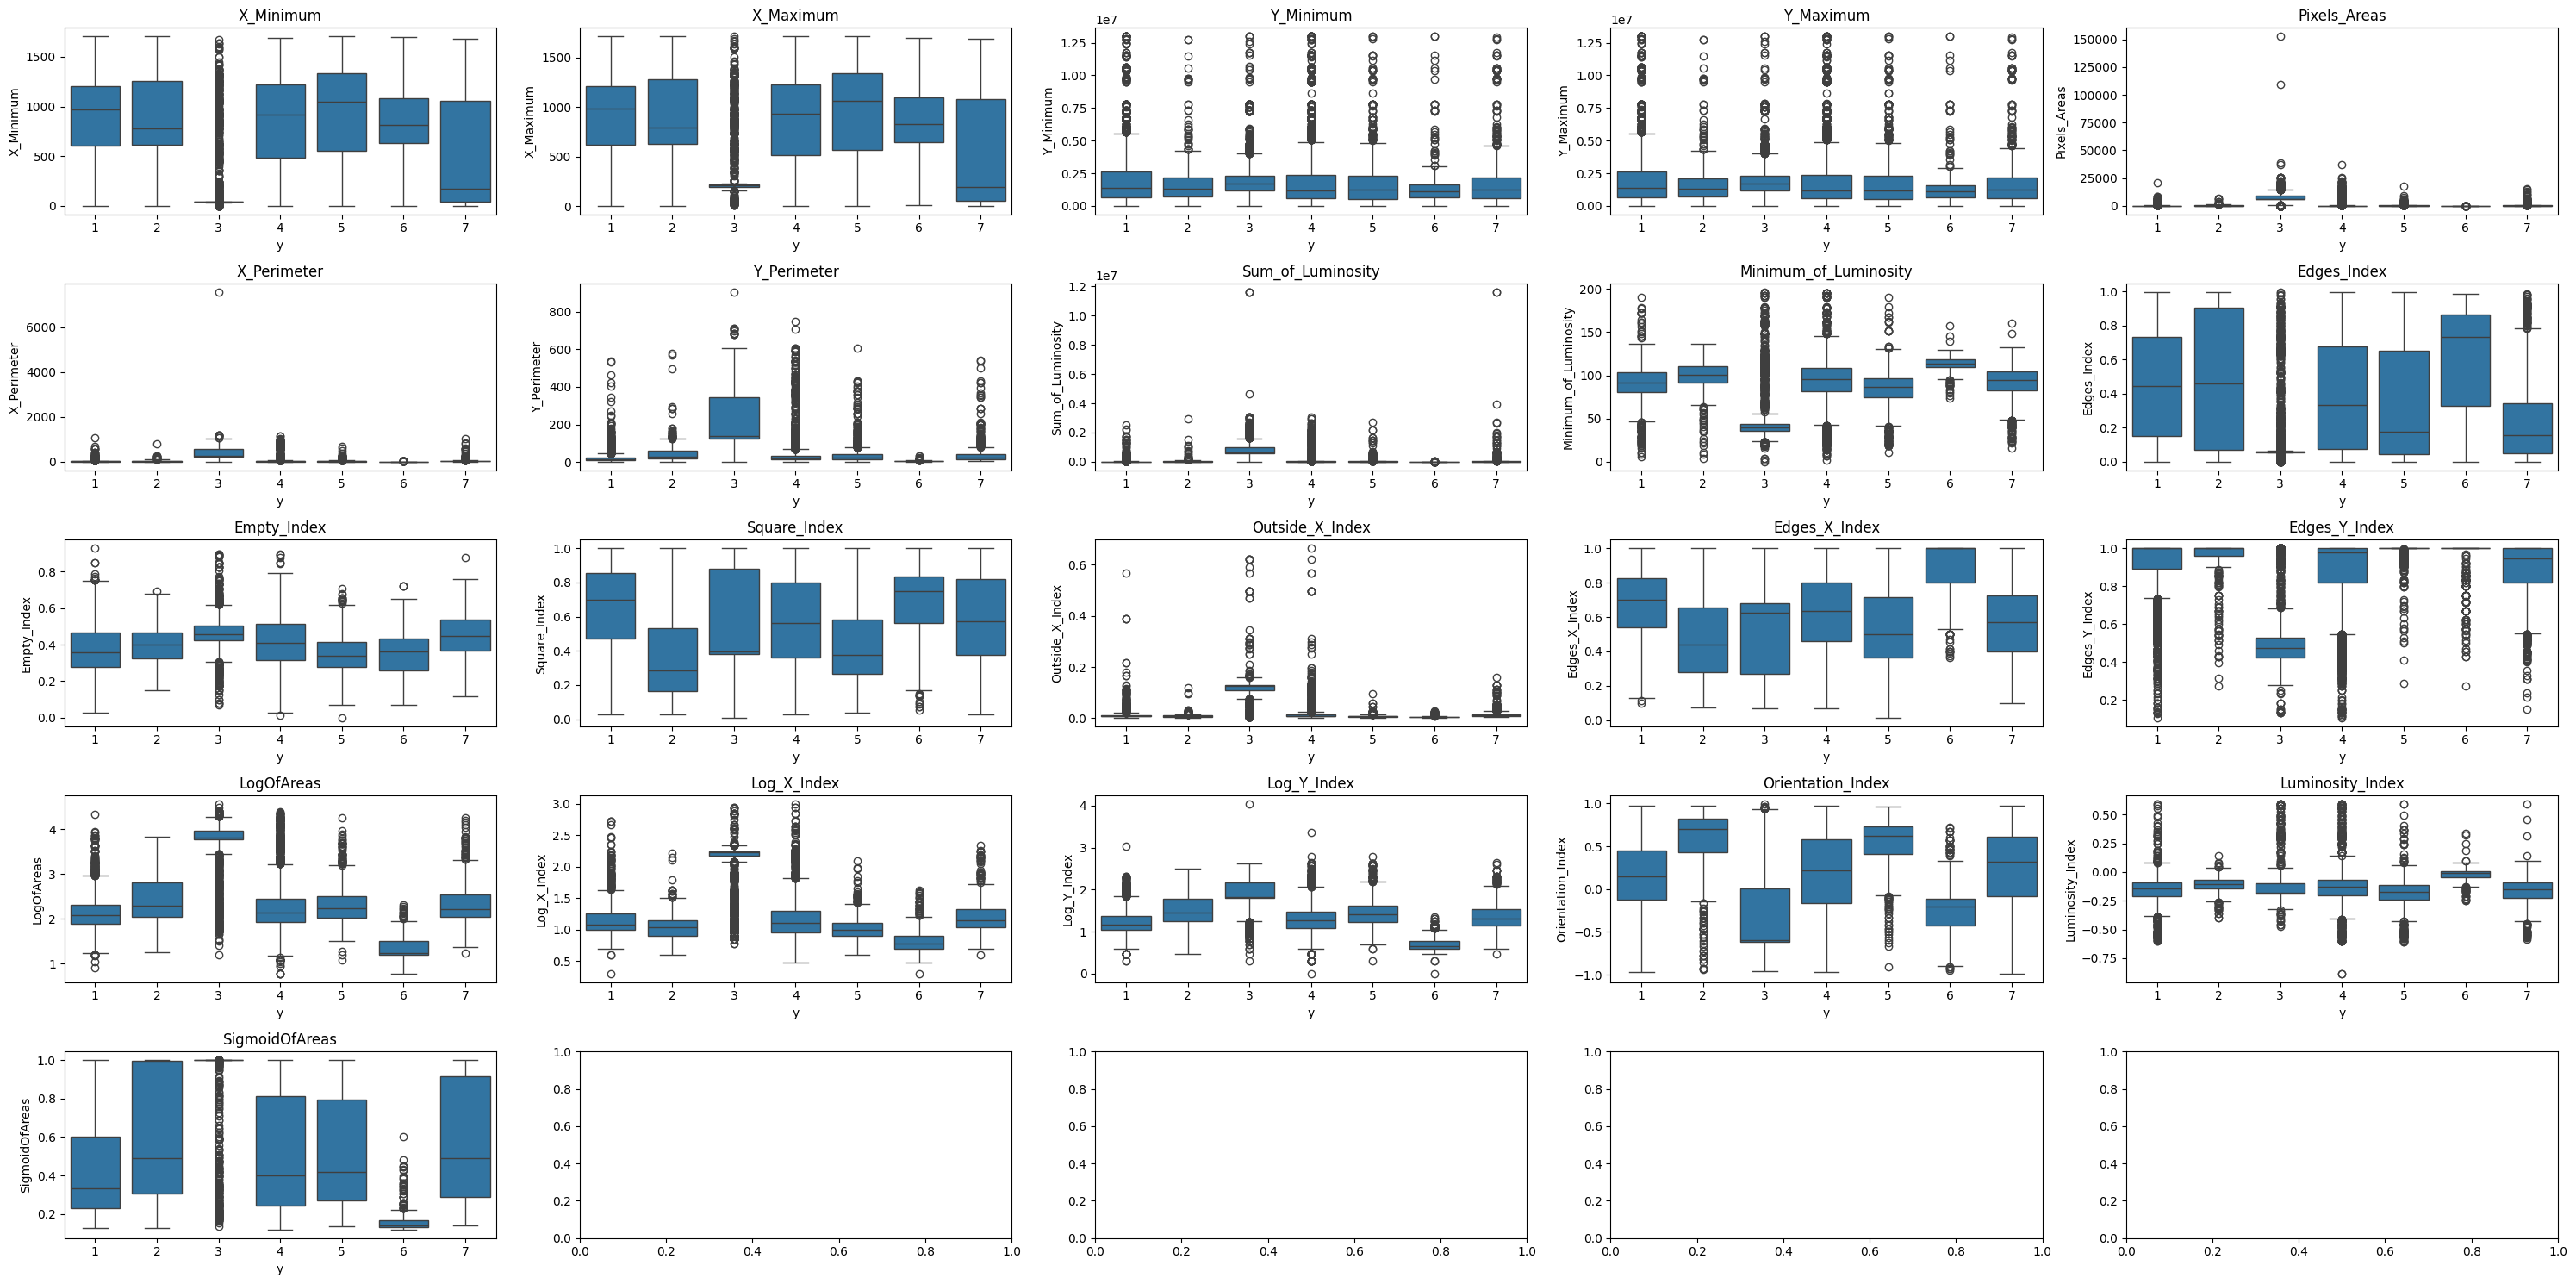

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(5,5,figsize=(30,15))

for i,col in enumerate(d.columns[1:-1]): # id, y제거
    sns.boxplot(data = d[[col,'y']],x= 'y',y=col,ax=ax.flatten()[i])
    ax.flatten()[i].set_title(col)

plt.tight_layout()
plt.show()

In [104]:
# # Pixels_Areas	X_Perimeter 두 개 컬럼의 iqr기준 상위 이상치들을 제거한다. class 3에서 다른 class 대비 큰 값을 보이므로

col = 'Pixels_Areas'
# q1 = d[col].quantile(0.25)
# q3 = d[col].quantile(0.75)
# iqr = q3-q1
upper = d[col].sort_values().values[-2]
d_preprocessing = d[(d[col] <upper)].reset_index(drop=True)

# col = 'X_Perimeter'
# # q1 = d1[col].quantile(0.25)
# # q3 = d1[col].quantile(0.75)
# # iqr = q3-q1
# # upper = q3 + iqr * 3
# # d_preprocessing = d1[(d1[col] <upper)].reset_index(drop=True)



머신러닝1-3      
1-3~1-7까지 문제는 종속변수가 1과 4인 데이터만 필터하여 작업을 진행한다.      
독립변수의 차원축소의 필요성에 대해서 설명하고 현 데이터에 대해 차원축소 작업의 타당성을 검토하라

In [135]:
f = d_preprocessing[d_preprocessing['y'].isin([1,4])]

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ss =StandardScaler()
pca = PCA()
f_ss = pd.DataFrame(ss.fit_transform(f.drop(columns =['id','y'])),columns =f.columns[1:-1])
pca.fit(f_ss)

evr = pd.DataFrame(pca.explained_variance_ratio_,columns =['explained_variance_ratio_'])
evr['cumsum'] = evr['explained_variance_ratio_'].cumsum()
evr.columns =['분산설명력','누적분산설명력']
evr.index =['주성분' + str(i) for i in range(1,22)]
display(evr)
pca_df = pd.DataFrame(pca.transform(f_ss),columns = ['pc'+ str(i) for i in range(1,22)]).iloc[:,:10]

,분산설명력,누적분산설명력
주성분1,0.334494,0.334494
주성분2,0.133458,0.467953
주성분3,0.101581,0.569534
주성분4,0.090023,0.659557
주성분5,0.086836,0.746393
주성분6,0.058960,0.805353
주성분7,0.041332,0.846685
주성분8,0.033467,0.880152
주성분9,0.027206,0.907358
주성분10,0.018627,0.925985


머신러닝1-4    
1-3에서 유효하다 판단한 데이터를 바탕(종속변수 y 컬럼제외)으로 kmeans 클러스터링을 진행한다.             
실루엣 계수와 엘보우 방법을 통해 적절한 k값을 선택하라 

In [211]:
y = f['y'].reset_index(drop=True).copy()

In [214]:
t = pd.concat([pca_df,y],axis=1)

In [165]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

it = []
sis = [] 

for n_clusters in range(2,15):
    km = KMeans(n_clusters=n_clusters,random_state=1) # 
    km.fit(pca_df)

    inertia = km.inertia_
    it.append(inertia)

    labels = km.predict(pca_df) # km.labels_ 동일
    sil = silhouette_score(pca_df,labels)
    sis.append(sil)



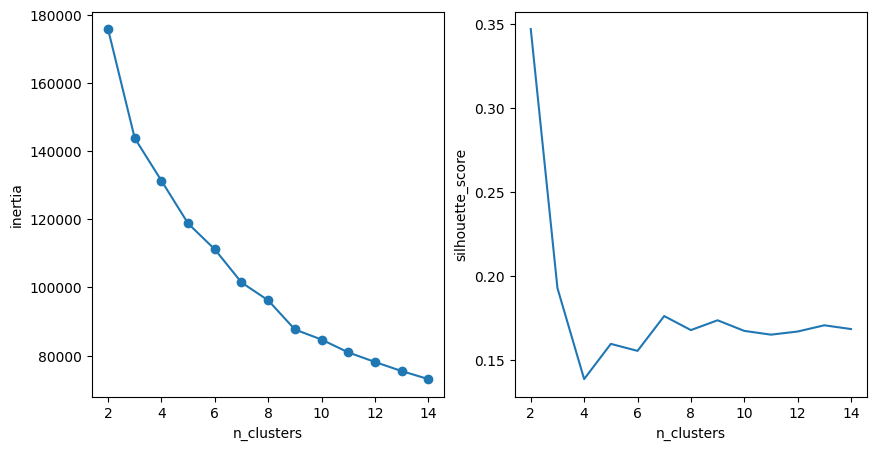

In [166]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(range(2,15),it,marker='o')
ax[1].plot(range(2,15),sis)
ax[0].set_xlabel('n_clusters')
ax[1].set_xlabel('n_clusters')

ax[0].set_ylabel('inertia')
ax[1].set_ylabel('silhouette_score')

plt.show()

In [167]:
# 실루엣과, 엘보우 방법으로 적절 클러스터 숫자는 7로 선정
km = KMeans(n_clusters=7)
km.fit(pca_df)

KMeans(n_clusters=7)

머신러닝 1-5     
1-4에서 판단한 적절한 K값을 바탕으로 클러스터링을 진행하고 두 개의 그래프를 그려라.       
그래프 1 : 두 개의 주성분 좌표(1-3에서 차원축소를 하지 않았었다면 차원축소를 진행하고 두개의 주성분만 추출한다)상에 scatter를 뿌리고 클러스터 label별로 색을 다르게 칠한다    
그래프 2 : 두 개의 주성분 좌표(1-3에서 차원축소를 하지 않았었다면 차원축소를 진행하고 두개의 주성분만 추출한다)상에 scatter를 뿌리고 종속변수y label(1 또는 4)별로 색을 다르게 칠한다

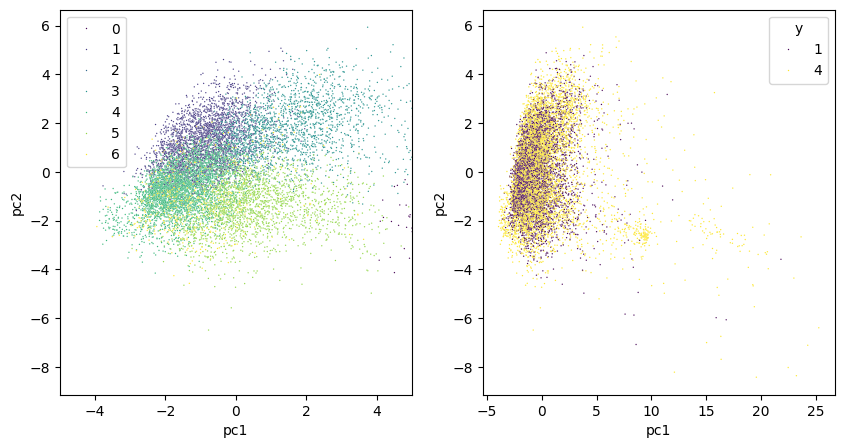

In [256]:
fig,ax = plt.subplots(1,2, figsize=(10,5))

sns.scatterplot(data=pca_df.iloc[:,:2],x ='pc1',y='pc2',ax=ax[0],s=1,hue=km.labels_,palette='viridis')
sns.scatterplot(data=pca_df.iloc[:,:2],x ='pc1',y='pc2',ax=ax[1],s=1,hue=t['y'],palette='viridis')

ax[0].set_xlim(-5,5)
plt.show()

머신러닝 1-6     
1-3에서 유효하다 판단한 데이터를 바탕(종속변수 y 컬럼제외)으로 dbscan 클러스터링을 진행한다.     
적절한 파라미터 튜닝을 통해 적절한 클러스터링 모델링을 진행하라. (이상치는 적당히 적으며 각 클러스터의 분포는 골고루 분포된)

In [273]:
from sklearn.cluster import DBSCAN # -1 레이블로 이상치를 표현한다. 
db = DBSCAN(eps=1.2,min_samples=10) # eps :반지름 , min_samples : 원 안에 들어가는 최소 숫자
db.fit(pca_df)
pd.Series(db.labels_).value_counts()

# for eps in [0.8, 1,1.2]:
#     for min_samples in [10,15,20,25]:
#         db = DBSCAN(eps=eps,min_samples= min_samples)

 0     5735
-1     5304
 3      111
 1       47
 2       30
 5       16
 7       12
 8       11
 4       10
 9       10
 6        8
 10       7
Name: count, dtype: int64

머신러닝 1-7    
1-6에서 판단한 적절한 클러스터링 모델을 통해 두 개의 그래프를 그려라.     
그래프 1 : 두 개의 주성분 좌표(1-3에서 차원축소를 하지 않았었다면 차원축소를 진행하고 두개의 주성분만 추출한다)상에 scatter를 뿌리고 클러스터 label별로 색을 다르게 칠한다    
그래프 2 : 두 개의 주성분 좌표(1-3에서 차원축소를 하지 않았었다면 차원축소를 진행하고 두개의 주성분만 추출한다)상에 scatter를 뿌리고 종속변수y label(1 또는 4)별로 색을 다르게 칠한다

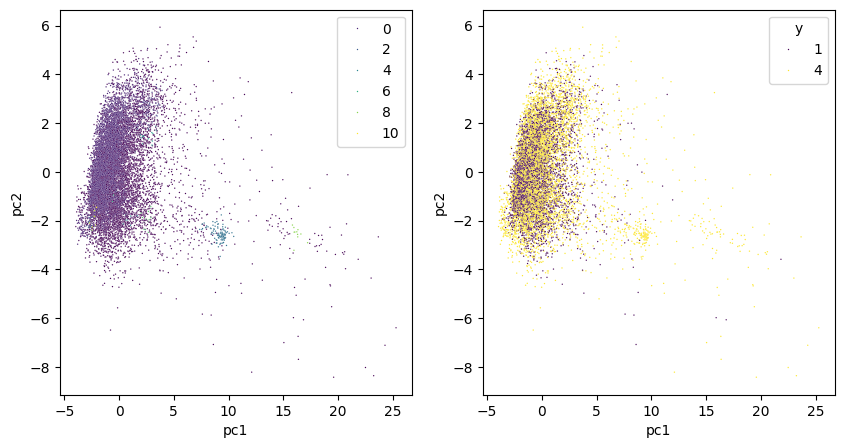

In [274]:
fig,ax = plt.subplots(1,2, figsize=(10,5))

sns.scatterplot(data=pca_df.iloc[:,:2],x ='pc1',y='pc2',ax=ax[0],s=1,hue=db.labels_,palette='viridis')
sns.scatterplot(data=pca_df.iloc[:,:2],x ='pc1',y='pc2',ax=ax[1],s=1,hue=t['y'],palette='viridis')

plt.show()

머신러닝 1-8     
1-2에서 전처리를 마친 데이터를 바탕으로 분류모델을 만들려고한다. 아래 기준을 바탕으로 전처리를 진행하여 모델링을하라     

1. 종속변수(y)가 3,5값을 가지는 데이터만 필터한다.
2. id의 1의 자리가 0 ~ 6인 경우 train으로 7 ~ 9인 경우 test로 한다.
3. 3개의 분류모델을 사용한다. 평가지표는 auc로 한다. 
4. 모델마다 train과 test 데이터 각각에 대해 roc-auc그래프를 그리고(총 6개) 해석한다 

In [ ]:
nf = d_preprocessing[d_preprocessing['y'].isin([3,5])].reset_index(drop=True)

train = nf[nf['id'].astype('str').str[-1].isin(['0','1','2','3','4','5','6'])].reset_index(drop=True)
test = nf[nf['id'].astype('str').str[-1].isin(['7','8','9'])].reset_index(drop=True)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc,roc_auc_score,roc_curve

train_x = train.drop(columns =['y'])
train_y = train['y']

test_x = test.drop(columns =['y'])
test_y = test['y']

rf = RandomForestClassifier(random_state=1)
rf.fit(train_x,train_y)

predict = rf.predict(train_x)
predict_proba = rf.predict_proba(train_x)[:,1]

test_predict = rf.predict(test_x)
test_predict_proba = rf.predict_proba(test_x)[:,1]

roc_auc_score(train_y, predict)
roc_auc_score(test_y, test_predict)
roc_auc_score(test_y, test_predict_proba)

train_x = train.drop(columns =['y'])
train_y = train['y']

test_x = test.drop(columns =['y'])
test_y = test['y']

svc = SVC(random_state=1,probability=True)
svc.fit(train_x,train_y)

predict = svc.predict(train_x)
predict_proba = svc.predict_proba(train_x)[:,1]

test_predict = svc.predict(test_x)
test_predict_proba = svc.predict_proba(test_x)[:,1]

roc_auc_score(test_y, test_predict_proba)

머신러닝 1-9     
1-2에서 전처리를 마친 데이터를 바탕으로 분류모델을 만들려고한다. 아래 기준을 바탕으로 전처리를 진행하여 모델링을하라     

1. 종속변수(y)가 3,5값을 가지는 데이터만 필터한다.
2. id의 1의 자리가 0 ~ 6인 경우 train으로 7 ~ 9인 경우 test로 한다.
3. 2개의 분류모델을 사용한다. 평가지표는 f1-score 한다. 
4. 각 모델을 학습하는데 있어서 3개 이상의 하이퍼 파라미터로 grid search를 진행한다.

In [307]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [315]:
train_x = train.drop(columns =['y'])
train_y = train['y']

test_x = test.drop(columns =['y'])
test_y = test['y']

rf = RandomForestClassifier(random_state=1)
parameters = {'max_depth':[2,5],'min_samples_split' : [2,5],'bootstrap': [True,False]}
clf = GridSearchCV(rf, parameters)
clf.fit(train_x,train_y)


GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 5],
                         'min_samples_split': [2, 5]})

In [316]:
clf.best_params_

{'bootstrap': True, 'max_depth': 5, 'min_samples_split': 5}

In [ ]:
clf.predict

In [332]:
clf.best_estimator_.feature_importances_

array([0.00088436, 0.0186939 , 0.01764562, 0.00067509, 0.00074221,
       0.11719007, 0.18355304, 0.030912  , 0.07236576, 0.0354828 ,
       0.0091711 , 0.00286883, 0.01974504, 0.07870195, 0.01049657,
       0.04593852, 0.08150294, 0.11150085, 0.0368584 , 0.03950488,
       0.01025395, 0.0753121 ])

머신러닝 1-10     
1-2에서 전처리를 마친 데이터를 바탕으로 분류모델을 만들려고한다. 아래 기준을 바탕으로 전처리를 진행하여 모델링을하라     

1. 종속변수(y)가 3,5,1값을 가지는 데이터만 필터한다.
2. id의 1의 자리가 0 ~ 6인 경우 train으로 7 ~ 9인 경우 test로 한다.
3. 2개의 분류모델을 사용한다. 평가지표는 f1-score 한다. 
4. 각 모델을 학습하는데 있어서 3개 이상의 하이퍼 파라미터로 grid search를 진행한다.

In [324]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc,roc_auc_score,roc_curve,f1_score

In [326]:
nf = d_preprocessing[d_preprocessing['y'].isin([3,5,1])].reset_index(drop=True)

train = nf[nf['id'].astype('str').str[-1].isin(['0','1','2','3','4','5','6'])].reset_index(drop=True)
test = nf[nf['id'].astype('str').str[-1].isin(['7','8','9'])].reset_index(drop=True)

train_x = train.drop(columns =['y'])
train_y = train['y']

test_x = test.drop(columns =['y'])
test_y = test['y']

rf = RandomForestClassifier(random_state=1)
parameters = {'max_depth':[2,5],'min_samples_split' : [2,5],'bootstrap': [True,False]}
clf = GridSearchCV(rf, parameters)
clf.fit(train_x,train_y)

GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 5],
                         'min_samples_split': [2, 5]})

In [327]:
test_predict = clf.best_estimator_.predict(test_x)

In [329]:
f1_score(test_y,test_predict,average='micro')

0.8329314502239064

머신러닝 1-11     
1-2에서 전처리를 마친 데이터를 바탕으로 분류모델을 만들려고한다. 아래 기준을 바탕으로 전처리를 진행하여 모델링을하라     

1. 종속변수(y)가 3,5값을 가지는 데이터만 필터한다.
2. id의 1의 자리가 0 ~ 6인 경우 train으로 7 ~ 9인 경우 test로 한다.
3. 2개의 분류모델을 사용한다. 평가지표는 accuracy로 한다. 
4. train모델을 평가하는데 있어 kfold방식으로 진행하고 평가한다. 최종 모델은 train 전체데이터로 학습하고 Test 데이터에 대해 평가하라

In [333]:
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
train -> kfold  / test 평가

In [334]:
import numpy as np
from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

kf = KFold(n_splits=2, random_state=None, shuffle=False)
for i, (train_index, val_index) in enumerate(kf.split(X)):
    train = train_df[train_index]
    val = val_df[val_index]
    
    model.fit()

    score = ~~

average_score 

# kfold문제에서 test 데이터가 별도로 있다면
# kfold는 score만 확인하고
# 최종모델은 train 전체 데이터로 학습하고 test로 평가한다.

sklearn.model_selection._split.KFold

In [335]:
from sklearn.model_selection import train_test_split

In [ ]:
train_test_split(X,y , stratify = y)

그 외 출제
- 오버 샘플링(smote), 언더샘플링, 이상치 탐지모델 (비지도학습)     
- 보팅, soft hard
- 딥러닝 (뉴럴넷 모델을 써라~)



출제 가능 (낮은 화귤)
- 요인분석 / 장바구니분석 / tsne(차원축소) / lda / 

In [337]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import IsolationForest # dbscan